# Analyse Détaillée du Modèle GBI (Goal-Based Investing)

Ce notebook explore tous les composants du modèle GBI :
1. **Courbe des taux** — Chargement, interpolation, évolution historique
2. **Goal Price Index (GPI / β)** — Prix de la rente cible, évolution
3. **Glide Path TDF** — Allocation cible intégrée dans le multiplicateur GBI
4. **Mécanique CPPI** — Chemin unique : plancher, coussin, allocation dynamique
5. **Monte Carlo complet** — Distribution des 500 scénarios
6. **Comparaison** — GBI vs TARGET_DATE vs FIXED_MIX
7. **Sensibilité au plancher** — Impact du paramètre `FLOOR_PERCENT_GBI`

In [1]:
import os, sys

# Auto-détection du répertoire ALM_modulaire
project_root = os.path.abspath('.')
if not os.path.exists(os.path.join(project_root, 'config')):
    project_root = os.path.abspath('..')
os.chdir(project_root)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Répertoire de travail : {os.getcwd()}")

Répertoire de travail : c:\Users\maxhe\Desktop\HSBC-Retirement-ALM\ALM_modulaire


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 11

from config import settings, profiles
from data import loader
from src import economics
from src.economics.yield_curve import YieldCurveBuilder
from src.liabilities.goal_price_index import GoalPriceIndex
from src.liabilities import contributions
from src.engine.gbi_core import run_simulation_gbi
from src.engine.core import run_simulation
from src.strategies import TargetDateStrategy, FixedMixStrategy
from src.analytics import metrics

print("Imports OK")

Imports OK


In [3]:
# ── Paramètres globaux ─────────────────────────────────────────────────────
NB_SIMS   = settings.NB_SIMULATIONS
NB_MOIS   = settings.NB_PERIODES_TOTAL
DATES     = pd.date_range(start=settings.DATE_DEBUT_T0, periods=NB_MOIS, freq='ME')
AGES      = settings.AGE_DEPART + np.arange(NB_MOIS) / 12.0

# ── Chargement de la courbe des taux ──────────────────────────────────────
yc  = YieldCurveBuilder().load_from_csv(settings.CSV_YIELD_CURVE)
gpi = GoalPriceIndex(yc, settings.DATE_RETRAITE_GBI, settings.DUREE_DECUMULATION_GBI)

# ── Chargement des paramètres de marché ───────────────────────────────────
mu_e, sigma_e, mu_b, sigma_b, corr_eb = loader.load_market_parameters()

print(f"Courbe des taux : {len(yc.dates)} observations ({yc.dates[0].date()} → {yc.dates[-1].date()})")
print(f"Simulation      : {NB_SIMS} scénarios × {NB_MOIS} mois")
print(f"Profil actif    : {settings.PROFIL_CHOISI}")
print(f"Plancher GBI    : {settings.FLOOR_PERCENT_GBI*100:.0f}%")

⚠️  Fichier Excel manquant, utilisation paramètres par défaut
Courbe des taux : 420 observations (1990-01-31 → 2024-12-31)
Simulation      : 500 scénarios × 480 mois
Profil actif    : EQUILIBRE
Plancher GBI    : 80%


---
## 1. Courbe des Taux — Visualisation et Interpolation

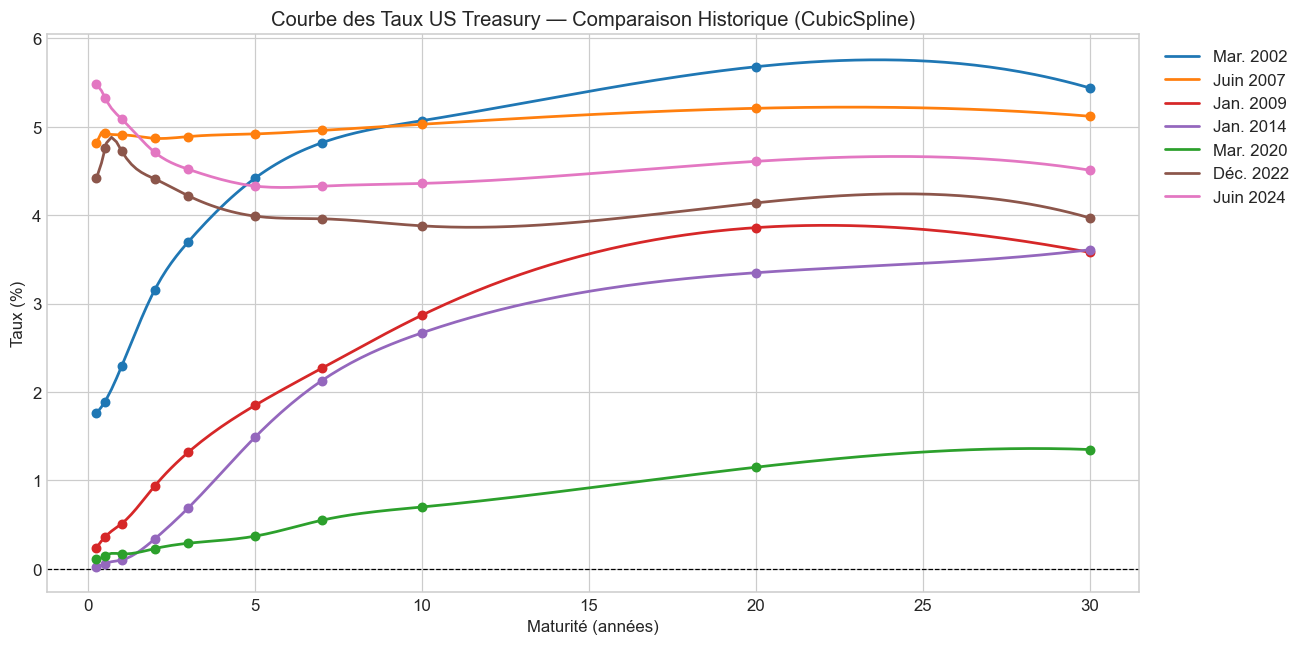

In [4]:
# ── Courbes des taux à différentes dates clés ─────────────────────────────
dates_cles = ['2002-01-31', '2007-06-30', '2009-01-31', '2014-01-31', '2020-03-31', '2022-12-31', '2024-06-30']
maturites  = [0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]
labels     = ['Mar. 2002', 'Juin 2007', 'Jan. 2009', 'Jan. 2014', 'Mar. 2020', 'Déc. 2022', 'Juin 2024']
couleurs   = ['#1f77b4', '#ff7f0e', '#d62728', '#9467bd', '#2ca02c', '#8c564b', '#e377c2']

fig, ax = plt.subplots(figsize=(12, 6))
for date, label, couleur in zip(dates_cles, labels, couleurs):
    taux = [yc.get_zero_rate(date, m) * 100 for m in maturites]
    # Courbe CubicSpline fine
    mat_fin = np.linspace(0.25, 30, 200)
    taux_fin = [yc.get_zero_rate(date, m) * 100 for m in mat_fin]
    ax.plot(mat_fin, taux_fin, color=couleur, lw=1.8, label=label)
    ax.scatter(maturites, taux, color=couleur, s=30, zorder=5)

ax.set_xlabel('Maturité (années)')
ax.set_ylabel('Taux (%)')
ax.set_title('Courbe des Taux US Treasury — Comparaison Historique (CubicSpline)')
ax.axhline(0, color='black', lw=0.8, ls='--')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

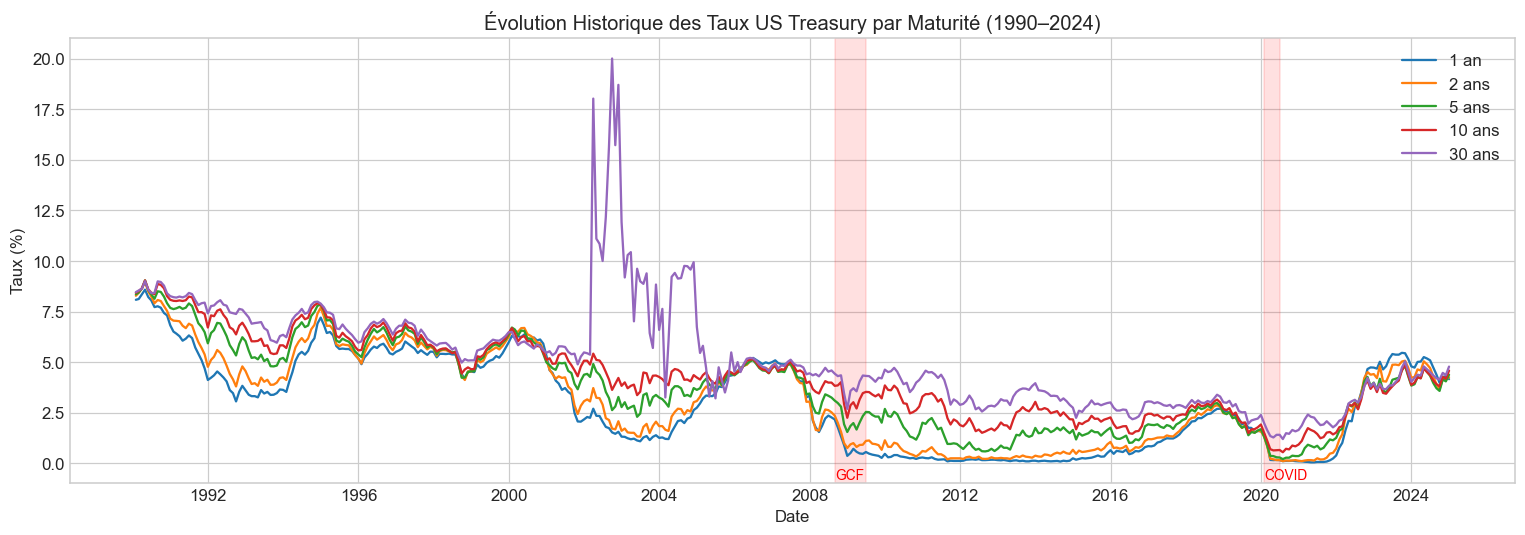

In [5]:
# ── Évolution temporelle des taux par maturité ────────────────────────────
maturites_track = [1, 2, 5, 10, 30]
labels_track    = ['1 an', '2 ans', '5 ans', '10 ans', '30 ans']
couleurs_track  = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, ax = plt.subplots(figsize=(14, 5))
for mat, label, couleur in zip(maturites_track, labels_track, couleurs_track):
    serie = [yc.get_zero_rate(d, mat) * 100 for d in yc.dates]
    ax.plot(yc.dates, serie, lw=1.5, label=label, color=couleur)

# Zones de crise
for (d1, d2, txt) in [('2008-09-01','2009-06-30','GCF'), ('2020-02-01','2020-06-30','COVID')]:
    ax.axvspan(pd.Timestamp(d1), pd.Timestamp(d2), alpha=0.12, color='red')
    ax.text(pd.Timestamp(d1), ax.get_ylim()[0] if ax.get_ylim()[0] > -1 else 0, txt,
            fontsize=9, color='red', va='bottom')

ax.set_xlabel('Date')
ax.set_ylabel('Taux (%)')
ax.set_title('Évolution Historique des Taux US Treasury par Maturité (1990–2024)')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ── Qualité de l'interpolation CubicSpline ────────────────────────────────
date_test = '2023-06-30'
idx_row  = yc.rates_data.index.searchsorted(pd.Timestamp(date_test))
row      = yc.rates_data.iloc[idx_row].dropna()
mat_obs  = row.index.astype(float).values
taux_obs = row.values * 100
mat_fin  = np.linspace(mat_obs.min(), mat_obs.max(), 300)
taux_spline = [yc.get_zero_rate(date_test, m) * 100 for m in mat_fin]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(mat_fin, taux_spline, color='#1f77b4', lw=2, label='CubicSpline (interpolation)')
ax.scatter(mat_obs, taux_obs, color='red', zorder=5, s=60, label='Données observées')
ax.set_xlabel('Maturité (années)')
ax.set_ylabel('Taux (%)')
ax.set_title(f"Interpolation CubicSpline — {date_test}")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Taux interpolés à {date_test} :")
for m in [0.25, 1, 2, 5, 10, 20, 30]:
    print(f"  Maturité {m:5.2f} ans : {yc.get_zero_rate(date_test, m)*100:.3f}%")

---
## 2. Goal Price Index (GPI / β) — Prix de la Rente Cible

$$\beta(t) = \sum_{k=0}^{N_{dec}} e^{-r(t,\, \tau_k) \cdot \tau_k}$$

- $\tau_k = \max(0, t_{ret}) + k$ : délai jusqu'au $k$-ième flux
- **Effet taux** : quand les taux montent → rente moins chère → $\beta$ baisse *(corrélation négative locale)*
- **Effet TTR** : quand on approche la retraite ($t_{ret}$ diminue) → les flux sont moins actualisés → $\beta$ monte *(tendance longue positive)*
- Sur la période 1990–2024, l'effet TTR domine la tendance. Sur des fenêtres courtes, l'effet taux domine.

In [ ]:
# ── Pré-calcul des betas sur tout l'historique ────────────────────────────
betas_historiques = gpi.compute_beta_series(yc.dates)
taux_10y = np.array([yc.get_zero_rate(d, 10) * 100 for d in yc.dates])

fig, axes = plt.subplots(3, 1, figsize=(14, 11))

# ── Subplot 1 : GPI historique ────────────────────────────────────────────
ax1 = axes[0]
ax1.plot(yc.dates, betas_historiques, color='#2E86AB', lw=2)
ax1.fill_between(yc.dates, 0, betas_historiques, alpha=0.15, color='#2E86AB')
ax1.set_ylabel('GPI (β)')
ax1.set_title(f'GPI sur l\'historique — Retraite {settings.DATE_RETRAITE_GBI} | Décumulation {settings.DUREE_DECUMULATION_GBI} ans\n'
              'Tendance haussière 1990→2020 dominée par le TTR décroissant | Chute 2022 = hausse des taux')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{x:.1f}'))

# ── Subplot 2 : Taux 10 ans ───────────────────────────────────────────────
ax2 = axes[1]
ax2.plot(yc.dates, taux_10y, color='#d62728', lw=1.5)
ax2.set_ylabel('Taux 10 ans (%)')
ax2.set_title('Taux 10 ans US Treasury')
ax2.set_xlabel('Date')

# ── Subplot 3 : Corrélation en variations mensuelles (effet taux pur) ─────
ax3 = axes[2]
dbeta = np.diff(betas_historiques)
drate = np.diff(taux_10y)
corr_monthly = np.corrcoef(dbeta, drate)[0, 1]

ax3.scatter(drate, dbeta, alpha=0.25, s=12, color='#2E86AB')
m, b = np.polyfit(drate, dbeta, 1)
x_line = np.linspace(drate.min(), drate.max(), 100)
ax3.plot(x_line, m * x_line + b, color='red', lw=2, label=f'Régression (pente={m:.2f})')
ax3.axhline(0, color='gray', ls=':', lw=0.8)
ax3.axvline(0, color='gray', ls=':', lw=0.8)
ax3.set_xlabel('Variation mensuelle du taux 10Y (%pt)')
ax3.set_ylabel('Variation mensuelle du GPI')
ax3.set_title(f'Corrélation mensuelle ΔβGPI vs ΔTaux 10Y : {corr_monthly:.3f}\n'
              'Effet taux pur (taux↑ → actualisation plus forte → β baisse)')
ax3.legend()

plt.tight_layout()
plt.show()

corr_total = np.corrcoef(betas_historiques, taux_10y)[0, 1]
print(f"Corrélation GPI / Taux 10Y (niveaux, 1990-2024) : {corr_total:+.3f}")
print(f"  → Dominée par l'effet TTR décroissant (tendance longue positive)")
print(f"Corrélation ΔβGPI / ΔTaux 10Y (variations mens.): {corr_monthly:+.3f}")
print(f"  → Effet taux pur : {'négatif (taux↑ => β↓, attendu)' if corr_monthly < 0 else 'positif (inattendu)'}")
print(f"\nBeta min : {betas_historiques.min():.2f}  ({yc.dates[betas_historiques.argmin()].date()})")
print(f"Beta max : {betas_historiques.max():.2f}  ({yc.dates[betas_historiques.argmax()].date()})")

In [ ]:
# ── Évolution du GPI sur l'horizon de simulation ─────────────────────────
# Phase backtest : GPI réel | Phase forecast : GPI constant (dernière valeur connue)
_, _, idx_split = economics.generators.generer_rendements_avec_backtest(
    mu_e, sigma_e, mu_b, sigma_b, corr_eb, DATES, settings.DATE_PIVOT_BACKTEST, 10
)

betas_sim_backtest = gpi.compute_beta_series(DATES[:idx_split])
beta_last          = gpi.calculate(DATES[idx_split - 1]) if idx_split > 0 else gpi.calculate(DATES[0])
betas_sim_forecast = np.full(len(DATES) - idx_split, beta_last)
betas_sim_all      = np.concatenate([betas_sim_backtest, betas_sim_forecast])

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(DATES[:idx_split], betas_sim_backtest, color='#2E86AB', lw=2, label='Backtest (courbe réelle)')
ax.plot(DATES[idx_split:], betas_sim_forecast, color='#ff7f0e', lw=2, ls='--', label='Forecast (constante)')
ax.axvline(pd.Timestamp(settings.DATE_PIVOT_BACKTEST), color='gray', ls=':', lw=1.5, label='Pivot backtest/forecast')
ax.axvline(pd.Timestamp(settings.DATE_RETRAITE_GBI), color='green', ls='--', lw=1.5, label='Date retraite')
ax.set_ylabel('GPI (β)')
ax.set_xlabel('Date')
ax.set_title('Évolution du GPI sur l\'Horizon de Simulation (avec transition backtest → forecast)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Durée backtest  : {idx_split} mois ({idx_split/12:.1f} ans)")
print(f"Durée forecast  : {len(DATES)-idx_split} mois ({(len(DATES)-idx_split)/12:.1f} ans)")

---
## 3. Glide Path TDF intégré au Multiplicateur GBI

In [ ]:
# ── Glide path TDF (identique à TargetDateStrategy) ──────────────────────
annees_ecoulees = AGES - settings.AGE_DEPART
alloc_tdf_serie = profiles.allocation_initiale - profiles.decroissance_annuelle * annees_ecoulees
alloc_tdf_serie = np.clip(alloc_tdf_serie, 0.05, 1.0)

floor_pct  = settings.FLOOR_PERCENT_GBI
mult_serie = alloc_tdf_serie / (1.0 - floor_pct + 1e-9)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

ax1.plot(DATES, alloc_tdf_serie * 100, color='#2E86AB', lw=2)
ax1.fill_between(DATES, 0, alloc_tdf_serie * 100, alpha=0.2, color='#2E86AB')
ax1.set_ylabel('Allocation cible PSP (%)')
ax1.set_title(f'Glide Path TDF — Profil {settings.PROFIL_CHOISI} '
              f'({profiles.allocation_initiale*100:.0f}% → {alloc_tdf_serie[-1]*100:.0f}%)')
ax1.set_ylim(0, 105)
ax1.axvline(pd.Timestamp(settings.DATE_RETRAITE_GBI), color='green', ls='--', lw=1.5)

ax2.plot(DATES, mult_serie, color='#ff7f0e', lw=2)
ax2.axhline(1.0, color='gray', ls=':', lw=1.2, label='Multiplicateur = 1')
ax2.fill_between(DATES, 0, mult_serie, alpha=0.2, color='#ff7f0e')
ax2.set_ylabel('Multiplicateur GBI (m)')
ax2.set_xlabel('Date')
ax2.set_title(f'Multiplicateur GBI = alloc_TDF / (1 - plancher) = alloc / {1-floor_pct:.2f}')
ax2.legend()
plt.tight_layout()
plt.show()

print(f"Multiplicateur initial : {mult_serie[0]:.2f}")
print(f"Multiplicateur final   : {mult_serie[-1]:.2f}")
print(f"\nInterprétation : w_PSP = min(1, m × coussin/W)")
print(f"  Si coussin = W×(1-plancher), alors w_PSP = alloc_TDF (comportement identique au TDF)")
print(f"  Si coussin petit, w_PSP < alloc_TDF (protection activée)")

---
## 4. Mécanique CPPI — Chemin Unique Détaillé

Simulation d'un chemin unique (scénario médian backtest) pour visualiser :
- Patrimoine vs Plancher vs Coussin
- Allocation PSP dynamique
- Interaction entre les hausses/baisses de marché et le plancher

In [ ]:
# ── Génération des scénarios ─────────────────────────────────────────────
np.random.seed(2024)
r_eq_all, r_bd_all, idx_split = economics.generators.generer_rendements_avec_backtest(
    mu_e, sigma_e, mu_b, sigma_b, corr_eb, DATES, settings.DATE_PIVOT_BACKTEST, NB_SIMS
)

# ── Simulation GBI ────────────────────────────────────────────────────────
mat_cap_gbi, courbe_inv_gbi, hist_app_gbi, hist_dd_gbi, hist_sal_gbi, hist_alloc_gbi = run_simulation_gbi(
    gpi, r_eq_all, r_bd_all, DATES, idx_split
)

# ── Simulation TDF ────────────────────────────────────────────────────────
settings.METHODE = 'TARGET_DATE'
tdf_strategy = TargetDateStrategy()
mat_cap_tdf, courbe_inv_tdf, hist_app_tdf, hist_dd_tdf, hist_sal_tdf = run_simulation(
    tdf_strategy, r_eq_all, r_bd_all, DATES
)

# ── Simulation Fixed Mix ──────────────────────────────────────────────────
settings.METHODE = 'FIXED_MIX'
fm_strategy = FixedMixStrategy()
mat_cap_fm, courbe_inv_fm, hist_app_fm, hist_dd_fm, hist_sal_fm = run_simulation(
    fm_strategy, r_eq_all, r_bd_all, DATES
)

print("Simulations complètes")
print(f"Capital médian final — GBI       : {np.median(mat_cap_gbi[-1,:]):>12,.0f} EUR")
print(f"Capital médian final — TDF       : {np.median(mat_cap_tdf[-1,:]):>12,.0f} EUR")
print(f"Capital médian final — Fixed Mix : {np.median(mat_cap_fm[-1,:]):>12,.0f} EUR")

In [ ]:
# ── Reconstruction du chemin unique pour détail CPPI ─────────────────────
# On prend le scénario médian comme référence
idx_p50 = np.argsort(mat_cap_gbi[-1, :])[NB_SIMS // 2]
r_eq_1  = r_eq_all[:, idx_p50]
r_bd_1  = r_bd_all[:, idx_p50]

# Pré-calcul contributions
app_init, app_max, t_pic = contributions.precalculer_parametres_apport_exponentiel(
    settings.SALAIRE_INITIAL, settings.SALAIRE_MAX_CIBLE, settings.NB_ANNEES_ACCUMULATION
)

# Reconstruction des betas pour ce chemin
betas_backtest = gpi.compute_beta_series(DATES[:idx_split])
betas_path     = np.concatenate([betas_backtest, np.zeros(NB_MOIS - idx_split)])
for t in range(max(idx_split, 1), NB_MOIS):
    betas_path[t] = betas_path[t-1] * (1.0 + r_bd_1[t-1])
betas_path = np.maximum(betas_path, 1e-6)

# Boucle de simulation détaillée (1 chemin)
W_hist       = np.zeros(NB_MOIS + 1)
floor_hist   = np.zeros(NB_MOIS)
cushion_hist = np.zeros(NB_MOIS)
alloc_hist   = np.zeros(NB_MOIS)
W_hist[0]    = settings.CAPITAL_INITIAL
W_annee      = settings.CAPITAL_INITIAL
beta_debut   = betas_path[0]
floor_pct    = settings.FLOOR_PERCENT_GBI

for k in range(NB_MOIS):
    t_annee = k / 12.0
    age     = settings.AGE_DEPART + t_annee
    W       = W_hist[k]
    W      += contributions.calculer_apport_exponentiel(t_annee, app_init, app_max, t_pic) if k > 0 else 0.0

    if k > 0 and DATES[k].month == 1 and DATES[k-1].month == 12:
        W_annee    = W
        beta_debut = betas_path[k]

    beta_safe     = max(beta_debut, 1e-9)
    floor_k       = floor_pct * (W_annee / beta_safe) * betas_path[k]
    cushion_k     = max(W - floor_k, 0.0)
    annees_ec     = age - settings.AGE_DEPART
    alloc_tdf_k   = max(0.05, min(1.0, profiles.allocation_initiale - profiles.decroissance_annuelle * annees_ec))
    m_k           = alloc_tdf_k / (1.0 - floor_pct + 1e-9)
    w_psp_k       = min(1.0, m_k * cushion_k / W) if W > 1e-9 else 0.0

    floor_hist[k]   = floor_k
    cushion_hist[k] = cushion_k
    alloc_hist[k]   = w_psp_k

    r_port     = w_psp_k * r_eq_1[k] + (1 - w_psp_k) * r_bd_1[k]
    W_hist[k+1] = max(W * (1 + r_port), 0.0)

dates_plot = pd.DatetimeIndex([pd.Timestamp(settings.DATE_DEBUT_T0)] + list(DATES))
print(f"Chemin unique (sim #{idx_p50}) — Capital final : {W_hist[-1]:,.0f} EUR")

In [ ]:
# ── Graphique CPPI détaillé (chemin unique) ───────────────────────────────
fig = plt.figure(figsize=(14, 12))
gs  = gridspec.GridSpec(3, 2, figure=fig)

# 1. Patrimoine vs Plancher
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(dates_plot, W_hist, color='#2E86AB', lw=2, label='Patrimoine W(t)')
ax1.plot(DATES, floor_hist, color='red', lw=1.8, ls='--', label=f'Plancher ({floor_pct*100:.0f}%)')
ax1.fill_between(DATES, floor_hist, np.minimum(W_hist[1:], W_hist[1:]), where=W_hist[1:]>floor_hist,
                  alpha=0.15, color='#2E86AB', label='Coussin')
ax1.plot(DATES, courbe_inv_gbi[1:], color='gray', ls=':', lw=1.2, label='Versements cumulés')
ax1.axvline(pd.Timestamp(settings.DATE_PIVOT_BACKTEST), color='orange', ls=':', lw=1.5, label='Pivot B/F')
ax1.axvline(pd.Timestamp(settings.DATE_RETRAITE_GBI), color='green', ls='--', lw=1.5, label='Retraite')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', ' ')))
ax1.set_title('GBI — Patrimoine, Plancher et Coussin (Scénario Médian)')
ax1.legend(loc='upper left', fontsize=9)
ax1.set_ylabel('Capital (EUR)')

# 2. Allocation PSP
ax2 = fig.add_subplot(gs[1, :])
ax2.stackplot(DATES, alloc_hist * 100, 100 - alloc_hist * 100,
               labels=['PSP (Actions)', 'Actif Sûr (Obligations)'],
               colors=['#F18F01', '#006BA6'], alpha=0.8)
ax2.plot(DATES, alloc_tdf_serie * 100, color='white', lw=1.5, ls='--', label='Cible TDF')
ax2.axvline(pd.Timestamp(settings.DATE_PIVOT_BACKTEST), color='orange', ls=':', lw=1.5)
ax2.axvline(pd.Timestamp(settings.DATE_RETRAITE_GBI), color='green', ls='--', lw=1.5)
ax2.set_ylabel('Allocation (%)')
ax2.set_ylim(0, 100)
ax2.set_title('Allocation Dynamique GBI — PSP vs Actif Sûr')
ax2.legend(loc='lower left', fontsize=9)

# 3. Coussin absolu
ax3 = fig.add_subplot(gs[2, 0])
ax3.fill_between(DATES, 0, cushion_hist, color='#2ca02c', alpha=0.6)
ax3.plot(DATES, cushion_hist, color='#2ca02c', lw=1.5)
ax3.set_title('Coussin = W(t) – Plancher(t)')
ax3.set_ylabel('Coussin (EUR)')
ax3.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', ' ')))

# 4. Rendements mensuels
ax4 = fig.add_subplot(gs[2, 1])
rdt_mensuel = np.diff(W_hist) / np.where(W_hist[:-1] > 0, W_hist[:-1], 1)
couleurs_rdt = ['#d62728' if r < 0 else '#2ca02c' for r in rdt_mensuel]
ax4.bar(DATES, rdt_mensuel * 100, color=couleurs_rdt, width=20, alpha=0.7)
ax4.axhline(0, color='black', lw=0.8)
ax4.set_title('Rendements Mensuels du Portefeuille GBI')
ax4.set_ylabel('Rendement (%)')

plt.tight_layout()
plt.show()

---
## 5. Simulation Monte Carlo Complète — Distribution GBI

In [ ]:
# ── Distribution des capitaux finaux ─────────────────────────────────────
cap_fin_gbi = mat_cap_gbi[-1, :]
cap_fin_tdf = mat_cap_tdf[-1, :]
cap_fin_fm  = mat_cap_fm[-1, :]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
binrange = (min(cap_fin_gbi.min(), cap_fin_tdf.min(), cap_fin_fm.min()),
             max(cap_fin_gbi.max(), cap_fin_tdf.max(), cap_fin_fm.max()))
bins_common = np.linspace(binrange[0], binrange[1], 40)

for ax, cap, label, couleur in zip(axes,
    [cap_fin_gbi, cap_fin_tdf, cap_fin_fm],
    ['GBI', 'TARGET DATE', 'FIXED MIX'],
    ['#2E86AB', '#A23B72', '#F18F01']):
    ax.hist(cap, bins=bins_common, color=couleur, alpha=0.75, edgecolor='white')
    p5, p50, p95 = np.percentile(cap, [5, 50, 95])
    ax.axvline(p5,  color='red',   ls='--', lw=1.8, label=f'P5 : {p5:,.0f}€')
    ax.axvline(p50, color='black', ls='-',  lw=2.2, label=f'P50: {p50:,.0f}€')
    ax.axvline(p95, color='green', ls='--', lw=1.8, label=f'P95: {p95:,.0f}€')
    ax.set_title(label)
    ax.legend(fontsize=8)
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))
    ax.set_xlabel('Capital final (EUR)')

plt.suptitle('Distribution des Capitaux Finaux à la Retraite', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ── Évolution des percentiles au fil du temps ─────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

for ax, mat, label, couleur in zip(axes,
    [mat_cap_gbi, mat_cap_tdf, mat_cap_fm],
    ['GBI', 'TARGET DATE', 'FIXED MIX'],
    ['#2E86AB', '#A23B72', '#F18F01']):

    p5_t  = np.percentile(mat, 5, axis=1)
    p50_t = np.percentile(mat, 50, axis=1)
    p95_t = np.percentile(mat, 95, axis=1)

    ax.fill_between(dates_plot, p5_t, p95_t, alpha=0.2, color=couleur)
    ax.plot(dates_plot, p95_t, color=couleur, lw=1.5, ls='--', label='P95')
    ax.plot(dates_plot, p50_t, color=couleur, lw=2.5, label='P50')
    ax.plot(dates_plot, p5_t,  color=couleur, lw=1.5, ls=':',  label='P5')
    ax.plot(dates_plot, np.concatenate([[settings.CAPITAL_INITIAL], courbe_inv_gbi[1:]]),
             color='gray', lw=1.2, ls='--', label='Versé cumulé')
    ax.axvline(pd.Timestamp(settings.DATE_PIVOT_BACKTEST), color='orange', ls=':', lw=1.2)
    ax.axvline(pd.Timestamp(settings.DATE_RETRAITE_GBI), color='green', ls='--', lw=1.2)
    ax.set_title(label)
    ax.legend(fontsize=8, loc='upper left')
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k€'))
    ax.set_xlabel('Date')

plt.suptitle('Évolution des Capitaux P5/P50/P95 — Comparaison', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ── Allocation PSP dynamique : distribution temporelle ───────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Heatmap allocation GBI
alloc_p25 = np.percentile(hist_alloc_gbi, 25, axis=1)
alloc_p50 = np.percentile(hist_alloc_gbi, 50, axis=1)
alloc_p75 = np.percentile(hist_alloc_gbi, 75, axis=1)

ax = axes[0]
ax.fill_between(DATES, alloc_p25 * 100, alloc_p75 * 100, alpha=0.3, color='#2E86AB', label='P25–P75')
ax.plot(DATES, alloc_p50 * 100, color='#2E86AB', lw=2, label='Médiane')
ax.plot(DATES, alloc_tdf_serie * 100, color='red', lw=1.8, ls='--', label='Cible TDF')
ax.axvline(pd.Timestamp(settings.DATE_PIVOT_BACKTEST), color='orange', ls=':', lw=1.5)
ax.set_ylim(0, 105)
ax.set_ylabel('Allocation PSP (%)')
ax.set_title('GBI — Distribution de l\'Allocation PSP (Actions)')
ax.legend()

# Histogramme final allocation
ax = axes[1]
ax.hist(hist_alloc_gbi[-1, :] * 100, bins=30, color='#2E86AB', alpha=0.75, edgecolor='white')
ax.axvline(alloc_tdf_serie[-1] * 100, color='red', ls='--', lw=2,
            label=f'Cible TDF finale : {alloc_tdf_serie[-1]*100:.1f}%')
ax.axvline(alloc_p50[-1] * 100, color='black', ls='-', lw=2,
            label=f'Médiane GBI : {alloc_p50[-1]*100:.1f}%')
ax.set_xlabel('Allocation PSP final (%)')
ax.set_title('Distribution de l\'Allocation PSP à la Retraite')
ax.legend()

plt.tight_layout()
plt.show()

---
## 6. Comparaison GBI vs TARGET DATE vs FIXED MIX

In [ ]:
# ── Tableau de métriques comparatives ────────────────────────────────────
resultats = {}

for nom, mat, hist_app in [
    ('GBI',        mat_cap_gbi, hist_app_gbi),
    ('TARGET DATE',mat_cap_tdf, hist_app_tdf),
    ('FIXED MIX',  mat_cap_fm,  hist_app_fm)
]:
    cap = mat[-1, :]
    total_investi = np.concatenate([[settings.CAPITAL_INITIAL], courbe_inv_gbi[1:]])[-1]
    idx_p50 = np.argsort(cap)[NB_SIMS // 2]
    tri = metrics.calculer_tri_annualise(settings.CAPITAL_INITIAL, hist_app, cap[idx_p50])
    kpis = metrics.calcul_kpi_complets(cap, total_investi, mat)
    coef_inf = 1 / ((1 + settings.TAUX_INFLATION) ** settings.NB_ANNEES_ACCUMULATION)
    resultats[nom] = {
        'P5  (EUR)':  f"{np.percentile(cap,  5):>12,.0f}",
        'P50 (EUR)':  f"{np.percentile(cap, 50):>12,.0f}",
        'P95 (EUR)':  f"{np.percentile(cap, 95):>12,.0f}",
        'TRI médian': f"{tri:>12.2f}%",
        'Dispersion': f"{kpis['dispersion']:>12,.0f}",
        'Shortfall':  f"{kpis['shortfall_prob']*100:>12.1f}%",
        'VaR 95%':    f"{kpis['var_95']:>12,.0f}",
        'Sortino':    f"{kpis['sortino']:>12.2f}",
        'Max DD(ans)':f"{kpis['max_underwater']:>12.1f}",
        'P5 réel':    f"{np.percentile(cap, 5)*coef_inf:>12,.0f}",
        'P50 réel':   f"{np.percentile(cap, 50)*coef_inf:>12,.0f}",
    }

df_kpi = pd.DataFrame(resultats).T
print("═" * 72)
print("MÉTRIQUES COMPARATIVES")
print("═" * 72)
print(df_kpi.to_string())
print("═" * 72)

In [ ]:
# ── Graphique comparatif P50 ──────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

donnees = [
    ('GBI',        mat_cap_gbi, '#2E86AB', '-'),
    ('TARGET DATE',mat_cap_tdf, '#A23B72', '--'),
    ('FIXED MIX',  mat_cap_fm,  '#F18F01', ':'),
]

for nom, mat, couleur, ls in donnees:
    p50 = np.percentile(mat, 50, axis=1)
    p5  = np.percentile(mat, 5,  axis=1)
    p95 = np.percentile(mat, 95, axis=1)
    ax1.plot(dates_plot, p50, color=couleur, lw=2, ls=ls, label=f'{nom} (médiane)')
    ax1.fill_between(dates_plot, p5, p95, alpha=0.07, color=couleur)

ax1.plot(dates_plot, np.concatenate([[settings.CAPITAL_INITIAL], courbe_inv_gbi[1:]]),
          color='gray', lw=1.2, ls='--', label='Versements')
ax1.axvline(pd.Timestamp(settings.DATE_PIVOT_BACKTEST), color='gray', ls=':', lw=1.2)
ax1.axvline(pd.Timestamp(settings.DATE_RETRAITE_GBI), color='green', ls='--', lw=1.5)
ax1.set_title('Capitaux P50 — Comparaison des 3 Stratégies')
ax1.legend()
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k€'))

# Box plot des capitaux finaux
ax2.boxplot(
    [mat_cap_gbi[-1, :], mat_cap_tdf[-1, :], mat_cap_fm[-1, :]],
    labels=['GBI', 'TARGET DATE', 'FIXED MIX'],
    notch=True, patch_artist=True,
    boxprops=dict(linewidth=1.5),
    medianprops=dict(color='black', linewidth=2),
    flierprops=dict(marker='.', markersize=3, alpha=0.4)
)
for patch, couleur in zip(ax2.patches, ['#2E86AB', '#A23B72', '#F18F01']):
    patch.set_facecolor(couleur)
    patch.set_alpha(0.6)
ax2.set_title('Distribution des Capitaux Finaux (Box Plot)')
ax2.set_ylabel('Capital final (EUR)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k€'))

plt.tight_layout()
plt.show()

In [ ]:
# ── Drawdown comparatif ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, hist_dd, nom, couleur in zip(axes,
    [hist_dd_gbi, hist_dd_tdf, hist_dd_fm],
    ['GBI', 'TARGET DATE', 'FIXED MIX'],
    ['#2E86AB', '#A23B72', '#F18F01']):

    dd_med = np.median(hist_dd, axis=1)
    dd_p5  = np.percentile(hist_dd, 5, axis=1)

    ax.fill_between(DATES, dd_p5 * 100, 0, alpha=0.3, color=couleur, label='Drawdown P5 (worst)')
    ax.plot(DATES, dd_med * 100, color=couleur, lw=1.8, label='Drawdown médian')
    ax.axhline(0, color='gray', lw=0.8)
    ax.set_title(nom)
    ax.set_ylabel('Drawdown (%)') if ax == axes[0] else None
    ax.set_xlabel('Date')
    ax.legend(fontsize=8)

plt.suptitle('Drawdown Médian et Worst-Case (P5) — Comparaison', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 7. Analyse de Sensibilité — Impact du Niveau de Plancher

In [ ]:
# ── Sensibilité au niveau du plancher ────────────────────────────────────
niveaux_plancher = [0.60, 0.70, 0.80, 0.90, 0.95]
resultats_floor  = {}

for floor in niveaux_plancher:
    settings.FLOOR_PERCENT_GBI = floor
    mat_tmp, _, hist_app_tmp, _, _, _ = run_simulation_gbi(
        gpi, r_eq_all, r_bd_all, DATES, idx_split
    )
    cap = mat_tmp[-1, :]
    total_investi = courbe_inv_gbi[-1]
    tri = metrics.calculer_tri_annualise(settings.CAPITAL_INITIAL, hist_app_tmp, cap[np.argsort(cap)[NB_SIMS//2]])
    kpis = metrics.calcul_kpi_complets(cap, total_investi, mat_tmp)
    resultats_floor[f"Floor {floor*100:.0f}%"] = {
        'P5':       np.percentile(cap, 5),
        'P50':      np.percentile(cap, 50),
        'P95':      np.percentile(cap, 95),
        'TRI (%)':  tri,
        'Disp.':    kpis['dispersion'],
        'Shortfall':kpis['shortfall_prob'] * 100,
        'mat_cap':  mat_tmp
    }
    print(f"Floor {floor*100:.0f}% — P50: {np.percentile(cap,50):>9,.0f} EUR | P5: {np.percentile(cap,5):>9,.0f} EUR | TRI: {tri:.2f}%")

# Réinitialiser le plancher d'origine
settings.FLOOR_PERCENT_GBI = 0.80

In [ ]:
# ── Graphique sensibilité ─────────────────────────────────────────────────
floors     = niveaux_plancher
p5_vals    = [resultats_floor[f"Floor {f*100:.0f}%"]['P5']  for f in floors]
p50_vals   = [resultats_floor[f"Floor {f*100:.0f}%"]['P50'] for f in floors]
p95_vals   = [resultats_floor[f"Floor {f*100:.0f}%"]['P95'] for f in floors]
disp_vals  = [resultats_floor[f"Floor {f*100:.0f}%"]['Disp.'] for f in floors]
short_vals = [resultats_floor[f"Floor {f*100:.0f}%"]['Shortfall'] for f in floors]
tri_vals   = [resultats_floor[f"Floor {f*100:.0f}%"]['TRI (%)'] for f in floors]

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# P5 / P50 / P95 vs floor
ax = axes[0, 0]
ax.plot([f*100 for f in floors], p95_vals, 'g-o', lw=2, label='P95 (optimiste)')
ax.plot([f*100 for f in floors], p50_vals, 'k-o', lw=2.5, label='P50 (médiane)')
ax.plot([f*100 for f in floors], p5_vals,  'r-o', lw=2, label='P5 (pessimiste)')
ax.axvline(80, color='gray', ls=':', lw=1.5, label='Paramètre défaut')
ax.set_xlabel('Niveau de Plancher (%)')
ax.set_ylabel('Capital final (EUR)')
ax.set_title('Capitaux finaux vs Niveau de Plancher')
ax.legend(fontsize=9)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k€'))

# Dispersion vs floor
ax = axes[0, 1]
ax.plot([f*100 for f in floors], disp_vals, '#2E86AB', marker='o', lw=2)
ax.axvline(80, color='gray', ls=':', lw=1.5)
ax.set_xlabel('Niveau de Plancher (%)')
ax.set_ylabel('Dispersion P95–P5 (EUR)')
ax.set_title('Dispersion vs Niveau de Plancher')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k€'))

# TRI vs floor
ax = axes[1, 0]
ax.plot([f*100 for f in floors], tri_vals, '#F18F01', marker='o', lw=2)
ax.axvline(80, color='gray', ls=':', lw=1.5)
ax.set_xlabel('Niveau de Plancher (%)')
ax.set_ylabel('TRI Médian (%/an)')
ax.set_title('TRI Médian vs Niveau de Plancher')

# Shortfall vs floor
ax = axes[1, 1]
ax.plot([f*100 for f in floors], short_vals, '#d62728', marker='o', lw=2)
ax.axvline(80, color='gray', ls=':', lw=1.5)
ax.set_xlabel('Niveau de Plancher (%)')
ax.set_ylabel('Probabilité de Shortfall (%)')
ax.set_title('Shortfall Risk vs Niveau de Plancher')

plt.suptitle('Sensibilité au Paramètre FLOOR_PERCENT_GBI', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ── Trajectoires P50 pour chaque niveau de plancher ──────────────────────
couleurs_floor = plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(floors)))

fig, ax = plt.subplots(figsize=(14, 6))
for floor, couleur in zip(floors, couleurs_floor):
    mat_tmp = resultats_floor[f"Floor {floor*100:.0f}%"]['mat_cap']
    p50 = np.percentile(mat_tmp, 50, axis=1)
    ax.plot(dates_plot, p50, color=couleur, lw=2,
             label=f'Floor {floor*100:.0f}% (P50={np.percentile(mat_tmp[-1,:],50)/1000:.0f}k€)')

# Référence TDF
p50_tdf = np.percentile(mat_cap_tdf, 50, axis=1)
ax.plot(dates_plot, p50_tdf, color='black', lw=2.5, ls='--', label='TARGET DATE (ref.)')

ax.axvline(pd.Timestamp(settings.DATE_PIVOT_BACKTEST), color='gray', ls=':', lw=1.5)
ax.axvline(pd.Timestamp(settings.DATE_RETRAITE_GBI), color='green', ls='--', lw=1.5)
ax.set_title('Trajectoires Médianes GBI selon le Niveau de Plancher')
ax.set_ylabel('Capital médian (EUR)')
ax.legend(loc='upper left', fontsize=9)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k€'))
plt.tight_layout()
plt.show()

---
## 8. Synthèse Finale

In [ ]:
# ── Tableau de synthèse final ─────────────────────────────────────────────
print("═" * 78)
print(f"SYNTHÈSE GBI — Profil : {settings.PROFIL_CHOISI} | Plancher : {settings.FLOOR_PERCENT_GBI*100:.0f}%")
print(f"Horizon : {settings.NB_ANNEES_ACCUMULATION} ans | Simulations : {NB_SIMS}")
print("═" * 78)

coef_inf = 1 / ((1 + settings.TAUX_INFLATION) ** settings.NB_ANNEES_ACCUMULATION)
print(f"\n{'Indicateur':<35} {'GBI':>12} {'TARGET DATE':>12} {'FIXED MIX':>12}")
print("-" * 75)

lignes = [
    ('Capital P5  nominal (EUR)', 5),
    ('Capital P50 nominal (EUR)', 50),
    ('Capital P95 nominal (EUR)', 95),
]
for label, pct in lignes:
    vals = [np.percentile(m[-1, :], pct) for m in [mat_cap_gbi, mat_cap_tdf, mat_cap_fm]]
    print(f"{label:<35} {vals[0]:>12,.0f} {vals[1]:>12,.0f} {vals[2]:>12,.0f}")

print("-" * 75)
cap_gbi, cap_tdf, cap_fm = mat_cap_gbi[-1,:], mat_cap_tdf[-1,:], mat_cap_fm[-1,:]
print(f"{'Dispersion P95-P5 (EUR)':<35} {np.percentile(cap_gbi,95)-np.percentile(cap_gbi,5):>12,.0f} "
      f"{np.percentile(cap_tdf,95)-np.percentile(cap_tdf,5):>12,.0f} "
      f"{np.percentile(cap_fm,95)-np.percentile(cap_fm,5):>12,.0f}")
print(f"{'Shortfall Risk (%)':<35} {(cap_gbi < courbe_inv_gbi[-1]).mean()*100:>11.1f}% "
      f"{(cap_tdf < courbe_inv_tdf[-1]).mean()*100:>11.1f}% "
      f"{(cap_fm < courbe_inv_fm[-1]).mean()*100:>11.1f}%")
print("═" * 78)
print("\nInterprétation du GBI :")
print("  - Le plancher dynamique garantit une protection du capital actualisé")
print("  - En contrepartie : upside potentiellement limité vs. TDF pur")
print("  - La dispersion réduite = moins d'incertitude pour l'épargnant")
print(f"  - Paramètre clé : FLOOR_PERCENT_GBI (actuellement {settings.FLOOR_PERCENT_GBI*100:.0f}%)")